# Wine Quality Dataset Project.



First I start by loading in packages for data analysis and visualization with numpy, pandas, matplotib, plotly, and seaborn.

## Data Exploration

In [3]:
#Installing Packages and Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots


Reading the wine quality dataset and creating a variable for it called df. I then printed the head and tail of the dataframe to see if the data was read in correctly.

In [4]:
df = pd.read_csv(r'/content/drive/MyDrive/DM 2 Project/train.csv')
print(df.head)

<bound method NDFrame.head of       fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0               6.5             0.430         0.28           12.00      0.056   
1               6.3             0.260         0.21            4.00      0.030   
2               6.4             0.160         0.32            8.75      0.038   
3               7.0             0.780         0.08            2.00      0.093   
4               7.0             0.220         0.33            2.10      0.052   
...             ...               ...          ...             ...        ...   
4745            4.6             0.445         0.00            1.40      0.053   
4746            7.7             0.570         0.21            1.50      0.069   
4747            8.9             0.120         0.45            1.80      0.075   
4748            7.3             0.330         0.47            2.10      0.077   
4749            7.4             0.400         0.29            5.40      0.044  

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Creating a new dataframe with quality as a categorical variable in case it is needed later in the project

In [ ]:
import pandas as pd

# Assuming df_mean_z3 is your DataFrame and 'quality' is the column to convert
df_cat = df
df_cat['quality_cat'] = df['quality'].astype('category')

# To check the conversion, you can print the data type of the column
#print(df['quality'].dtype)

Next, I visualize the data before preprocessing to get an idea of what the data looks like.

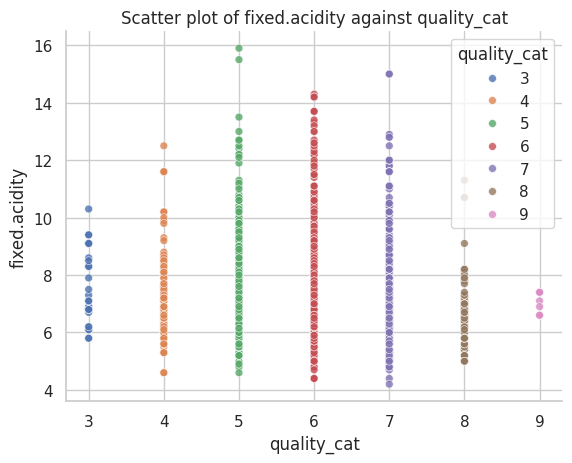

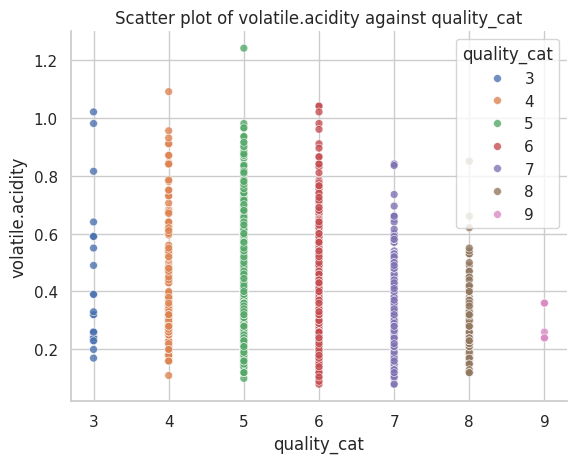

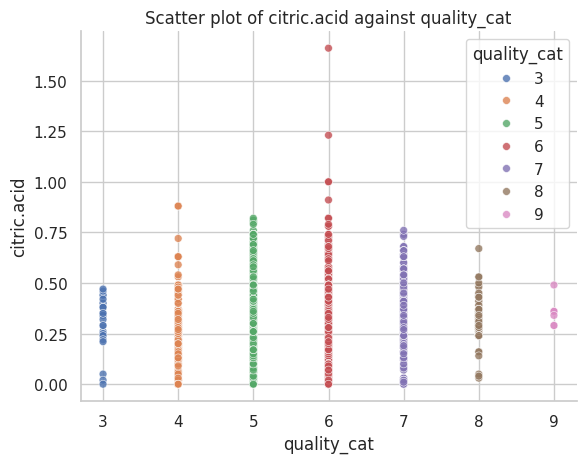

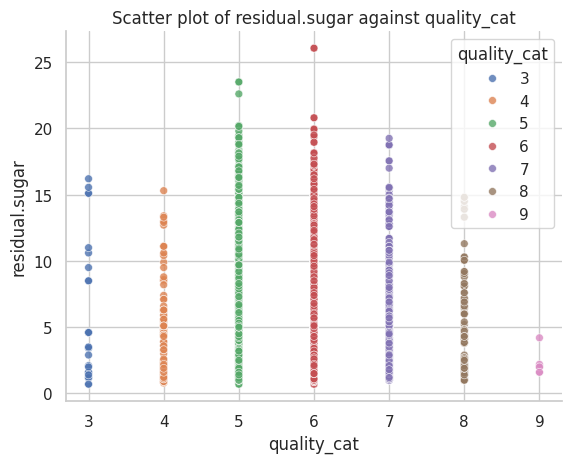

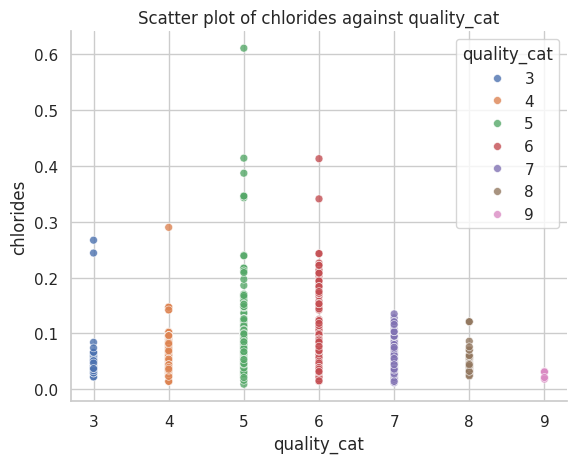

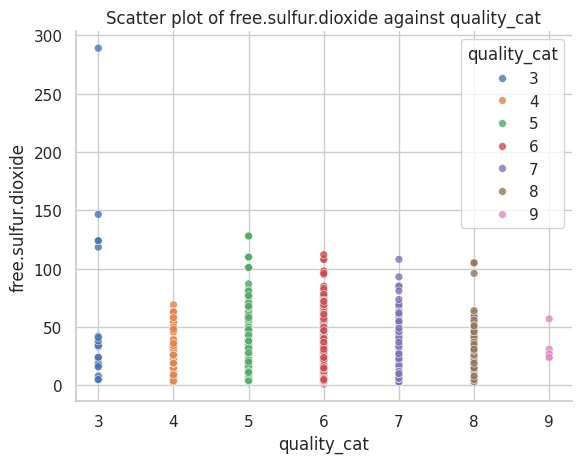

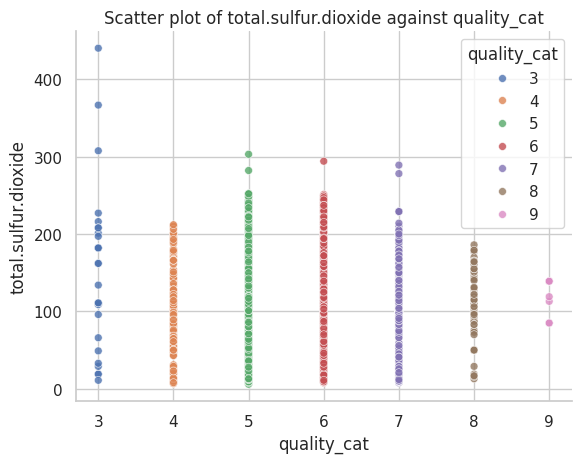

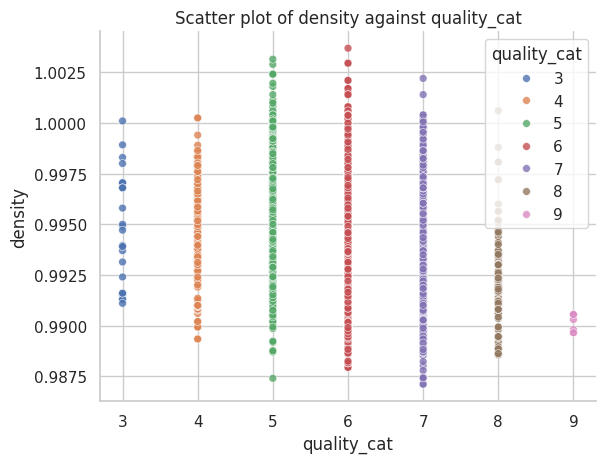

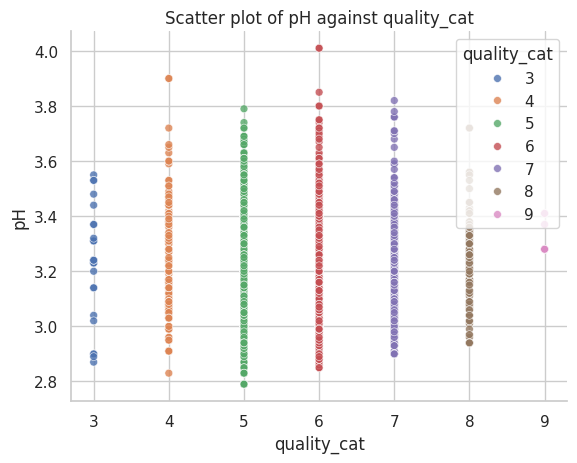

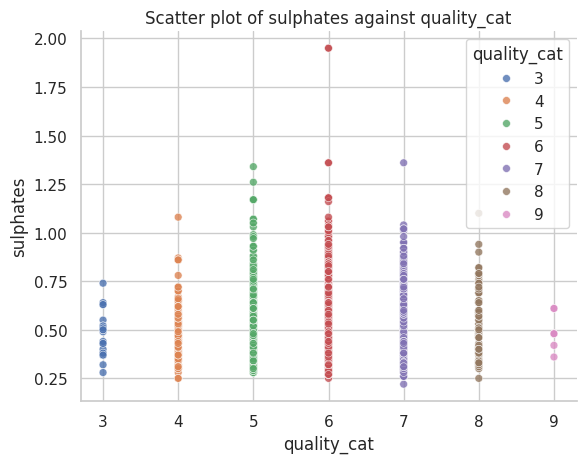

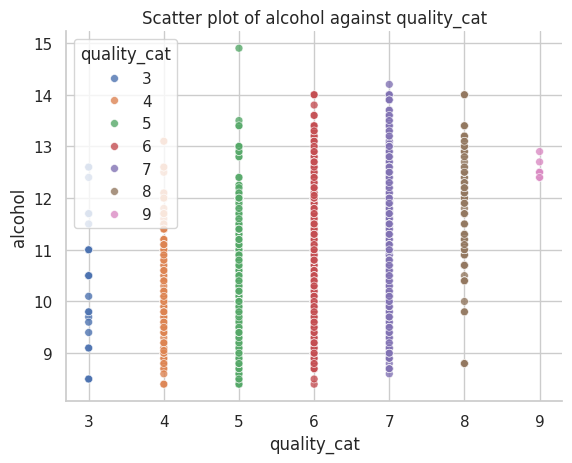

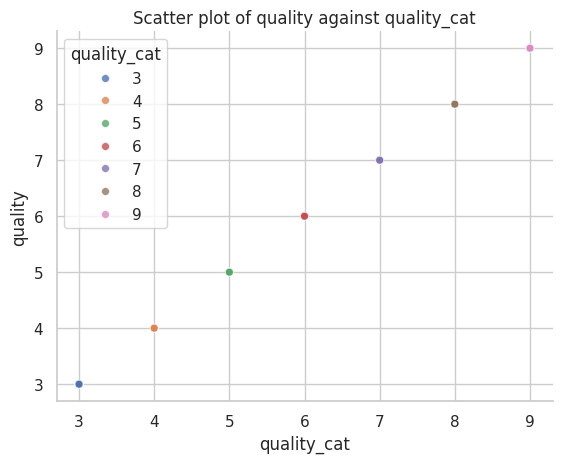

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
x_column = 'quality_cat'

# Set the style of seaborn
sns.set(style="whitegrid")

# Loop over the columns of the DataFrame
for y_column in df.columns:
    # Skip the x_column itself
    if y_column == x_column:
        continue

    # Create a scatter plot for each column using seaborn
    sns.scatterplot(data=df_cat, x=x_column, y=y_column, hue="quality_cat", s=32, alpha=0.8)

    # Customize plot appearance
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add title for the current column
    plt.title(f'Scatter plot of {y_column} against {x_column}')

    # Show the plot
    plt.show()


Scatter Plot by with quality by color. It just makes it a little easier to distinguish different qualities

Interactive histogram graph colored by quality. Lots of interesting observations.

In [ ]:
import plotly.express as px

# Loop over the columns of the DataFrame
for y_column in df_cat.columns:
    # Create a histogram for each column with shaded color categories
    fig = px.histogram(df_cat, x=y_column, color='quality_cat',
                       barmode='overlay', opacity=0.6)  # 'overlay' allows the bars to be plotted over one another with transparency

    # Update layout to improve visibility and aesthetics
    fig.update_layout(
        title=f'Histogram of {y_column} by quality categories',
        xaxis_title=y_column,
        yaxis_title='Count',
        legend_title='Quality Categories'
    )

    # Show the plot
    fig.show()


Visualizations notes:
* fixed.acidity has mixed results, not much correlation
* lower volatile acidity leads to higher quality
* medium citric acid leads to higher quality
* residual sugar is pretty mixed,
* low chlorides leads to higher quality
* free.sulfur above 110 leads to low quality
* low to medium total.sulfur dioxide leads to high quality
* low density leads to high quality
* medium ph leads to high quality
* sulphates is mixed
* high alcohol leads to high quality

Next, I'm going to run a correlation matrix to see how the attributes and correlated to each other including quality. This will help later in feature selection.

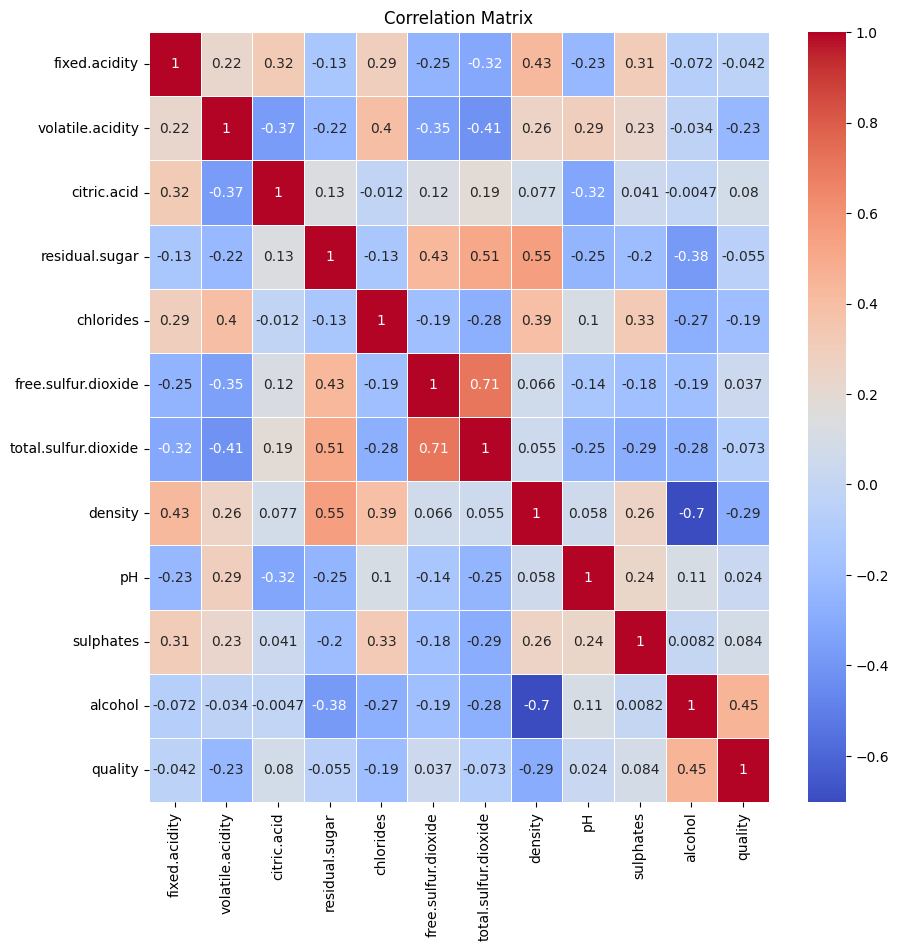

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

This correlation matrix is important for two reasons. It shows the correlation between the dimensions and my target variable, quality. It then also shows the correlation between each dimension. This will be important for dimension reduction for optimizing my model. Takeaways are:



*   Highest positive correlation with quality: alcohol (.45)
*   Highest negative correlation with quality: density (-.29), volatile.acidity (-.23), chlorides (-.19)
*   Alcohol has highest positive correlation and density has highest negative correlation with quality. Interesting to see that alcohol has a -.7 correlation with density, could do something with this.
*   Total.sulfur and free.sulfur have a correlation of .71, could use this in dimension reduction.



## Outlier Detection

Creating dotplots to get a view of how many outliers there are for each features.

<Axes: >

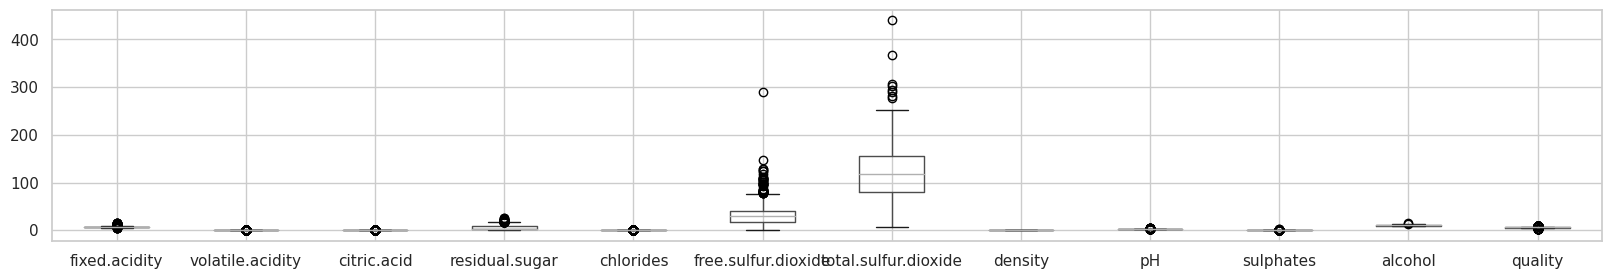

In [ ]:
import matplotlib

df.boxplot(figsize=(20,3))

There were many outliers, but after running multiple models, a dataset with the outliers left in performed better.

Creating a dataset removing records with observations with z-scores larger than 4.

In [ ]:
#Z-score as 4

import pandas as pd
import numpy as np

def remove_outliers_z_score_verbose(data, z_threshold=3, ignore_column=None):
    # Identify numeric columns and remove the ignored column from the list if specified
    if ignore_column and ignore_column in data.columns:
        numeric_cols = data.select_dtypes(include=[np.number]).columns.drop(ignore_column)
    else:
        numeric_cols = data.select_dtypes(include=[np.number]).columns

    results = data.copy()
    removed_rows = []

    for column in numeric_cols:
        # Calculate z-scores for the column
        column_z_scores = (data[column] - data[column].mean()) / data[column].std()
        # Identify outliers in the column
        outliers = data[np.abs(column_z_scores) > z_threshold]

        # Append reasons for each removed row
        for index, row in outliers.iterrows():
            removed_rows.append({'Index': index, 'Column': column, 'Value': row[column], 'Z-Score': column_z_scores[index]})

        # Remove identified outliers from the dataset
        results = results[np.abs(column_z_scores) <= z_threshold]

    # Print removed rows
    if removed_rows:
        print("Removed rows and reasons:")
        for row in removed_rows:
            print(f"Index {row['Index']}: {row['Column']} had value {row['Value']} (Z-Score: {row['Z-Score']:.2f})")
    else:
        print("No outliers detected.")

    return results

# Example usage
df_z4 = remove_outliers_z_score_verbose(df, z_threshold=4, ignore_column='quality')
print(df_z4.head)

Removed rows and reasons:
Index 46: fixed.acidity had value 14.3 (Z-Score: 5.71)
Index 153: fixed.acidity had value 12.8 (Z-Score: 4.51)
Index 192: fixed.acidity had value 12.2 (Z-Score: 4.03)
Index 415: fixed.acidity had value 12.4 (Z-Score: 4.19)
Index 503: fixed.acidity had value 12.2 (Z-Score: 4.03)
Index 526: fixed.acidity had value 12.5 (Z-Score: 4.27)
Index 748: fixed.acidity had value 13.0 (Z-Score: 4.67)
Index 752: fixed.acidity had value 13.7 (Z-Score: 5.23)
Index 755: fixed.acidity had value 13.3 (Z-Score: 4.91)
Index 820: fixed.acidity had value 15.0 (Z-Score: 6.28)
Index 987: fixed.acidity had value 12.5 (Z-Score: 4.27)
Index 1033: fixed.acidity had value 15.9 (Z-Score: 7.00)
Index 1217: fixed.acidity had value 13.4 (Z-Score: 4.99)
Index 1747: fixed.acidity had value 12.9 (Z-Score: 4.59)
Index 1954: fixed.acidity had value 12.7 (Z-Score: 4.43)
Index 1983: fixed.acidity had value 12.6 (Z-Score: 4.35)
Index 2077: fixed.acidity had value 12.2 (Z-Score: 4.03)
Index 2102: fixed

Here is the function to normalize the dataset by giving each column a mean of 0 and a standard deviation of 1.

In [8]:
import pandas as pd

def normalize(df):
    # Exclude the 'quality' column from normalization
    columns_to_normalize = df.columns[df.columns != 'quality']
    df_normalized = df.copy()  # Make a copy to avoid modifying the original DataFrame
    df_normalized[columns_to_normalize] = (df_normalized[columns_to_normalize] - df_normalized[columns_to_normalize].mean()) / \
                                          df_normalized[columns_to_normalize].std()
    return df_normalized

Normalized copy with the outliers removed

In [ ]:
# Example usage
df_mean_z4 = normalize(df_z4.copy())  # Operate on a copy to avoid modifying original data
print(df_mean_z4)

      fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0         -0.564149          0.660966    -0.265596        1.371572   0.127247   
1         -0.742736         -0.457404    -0.772843       -0.323431  -0.979390   
2         -0.653443         -1.115269     0.024259        0.682977  -0.638887   
3         -0.117681          2.963493    -1.714872       -0.747181   1.702077   
4         -0.117681         -0.720550     0.096723       -0.725994  -0.043005   
...             ...               ...          ...             ...        ...   
4745      -2.260729          0.759646    -2.294582       -0.874307  -0.000442   
4746       0.507375          1.581977    -0.772843       -0.853119   0.680566   
4747       1.578899         -1.378414     0.966288       -0.789556   0.935944   
4748       0.150200          0.003102     1.111216       -0.725994   1.021070   
4749       0.239494          0.463607    -0.193132       -0.026805  -0.383509   

      free.sulfur.dioxide  

Normalized copy with outliers still present

In [9]:
# Example usage
df_mean = normalize(df.copy())  # Operate on a copy to avoid modifying original data
print(df_mean)

      fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0         -0.549244          0.620458    -0.273570        1.376813   0.032293   
1         -0.709861         -0.467096    -0.762351       -0.317860  -0.812314   
2         -0.629552         -1.106834     0.005733        0.688352  -0.552435   
3         -0.147700          2.859542    -1.670087       -0.741529   1.234235   
4         -0.147700         -0.722992     0.075559       -0.720345  -0.097646   
...             ...               ...          ...             ...        ...   
4745      -2.075108          0.716419    -2.228694       -0.868629  -0.065161   
4746       0.414460          1.516092    -0.762351       -0.847446   0.454597   
4747       1.378164         -1.362730     0.913469       -0.783896   0.649507   
4748       0.093226         -0.019280     1.053121       -0.720345   0.714476   
4749       0.173534          0.428537    -0.203744       -0.021293  -0.357525   

      free.sulfur.dioxide  

 A normalized copy of the dataset with quality as a categorical variable if needed.

In [ ]:
def normalize(df):
    # Create a copy of the DataFrame to avoid modifying the original data
    df_normalized = df.copy()
    # Select all columns except 'quality_cat'
    cols_to_normalize = df_normalized.columns[df_normalized.columns != 'quality_cat']
    # Normalize each column
    for col in cols_to_normalize:
        df_normalized[col] = (df_normalized[col] - df_normalized[col].mean()) / df_normalized[col].std()
    return df_normalized

# Example usage
df_mean_cat = normalize(df_cat.copy())  # Operate on a copy to avoid modifying original data
print(df_mean_cat)

df_mean_cat = df_mean_cat.drop(columns=['quality'], inplace=False)
print(df_mean_cat)

      fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0         -0.549244          0.620458    -0.273570        1.376813   0.032293   
1         -0.709861         -0.467096    -0.762351       -0.317860  -0.812314   
2         -0.629552         -1.106834     0.005733        0.688352  -0.552435   
3         -0.147700          2.859542    -1.670087       -0.741529   1.234235   
4         -0.147700         -0.722992     0.075559       -0.720345  -0.097646   
...             ...               ...          ...             ...        ...   
4745      -2.075108          0.716419    -2.228694       -0.868629  -0.065161   
4746       0.414460          1.516092    -0.762351       -0.847446   0.454597   
4747       1.378164         -1.362730     0.913469       -0.783896   0.649507   
4748       0.093226         -0.019280     1.053121       -0.720345   0.714476   
4749       0.173534          0.428537    -0.203744       -0.021293  -0.357525   

      free.sulfur.dioxide  

Amount of rows removed after outlier detection of record with a z-score > 4.

In [140]:
len(df)-len(df_mean_z4)

126

In [141]:
len(df)-len(df_mean)

0

In [142]:
len(df)-len(df_mean_cat)

0

!24 Records removed with outlier detection

Counting occurences of each wine quality

In [ ]:
import pandas as pd

# Assuming df_mean_z3 is your DataFrame and 'quality' is the column to analyze
quality_counts = df_mean_z4['quality'].value_counts()

# Print the counts of each quality value
print("Counts of each quality value:")
print(quality_counts)

import pandas as pd

# Assuming df_mean_z3 is your DataFrame and 'quality' is the column to analyze
quality_counts = df_mean['quality'].value_counts()

# Print the counts of each quality value
print("Counts of each quality value:")
print(quality_counts)


Counts of each quality value:
quality
6    2049
5    1500
7     789
4     149
8     113
3      17
9       7
Name: count, dtype: int64
Counts of each quality value:
quality
6    2114
5    1536
7     796
4     154
8     116
3      27
9       7
Name: count, dtype: int64


Removing outliers might hurt model because it removes half of the occurences of quality 3.

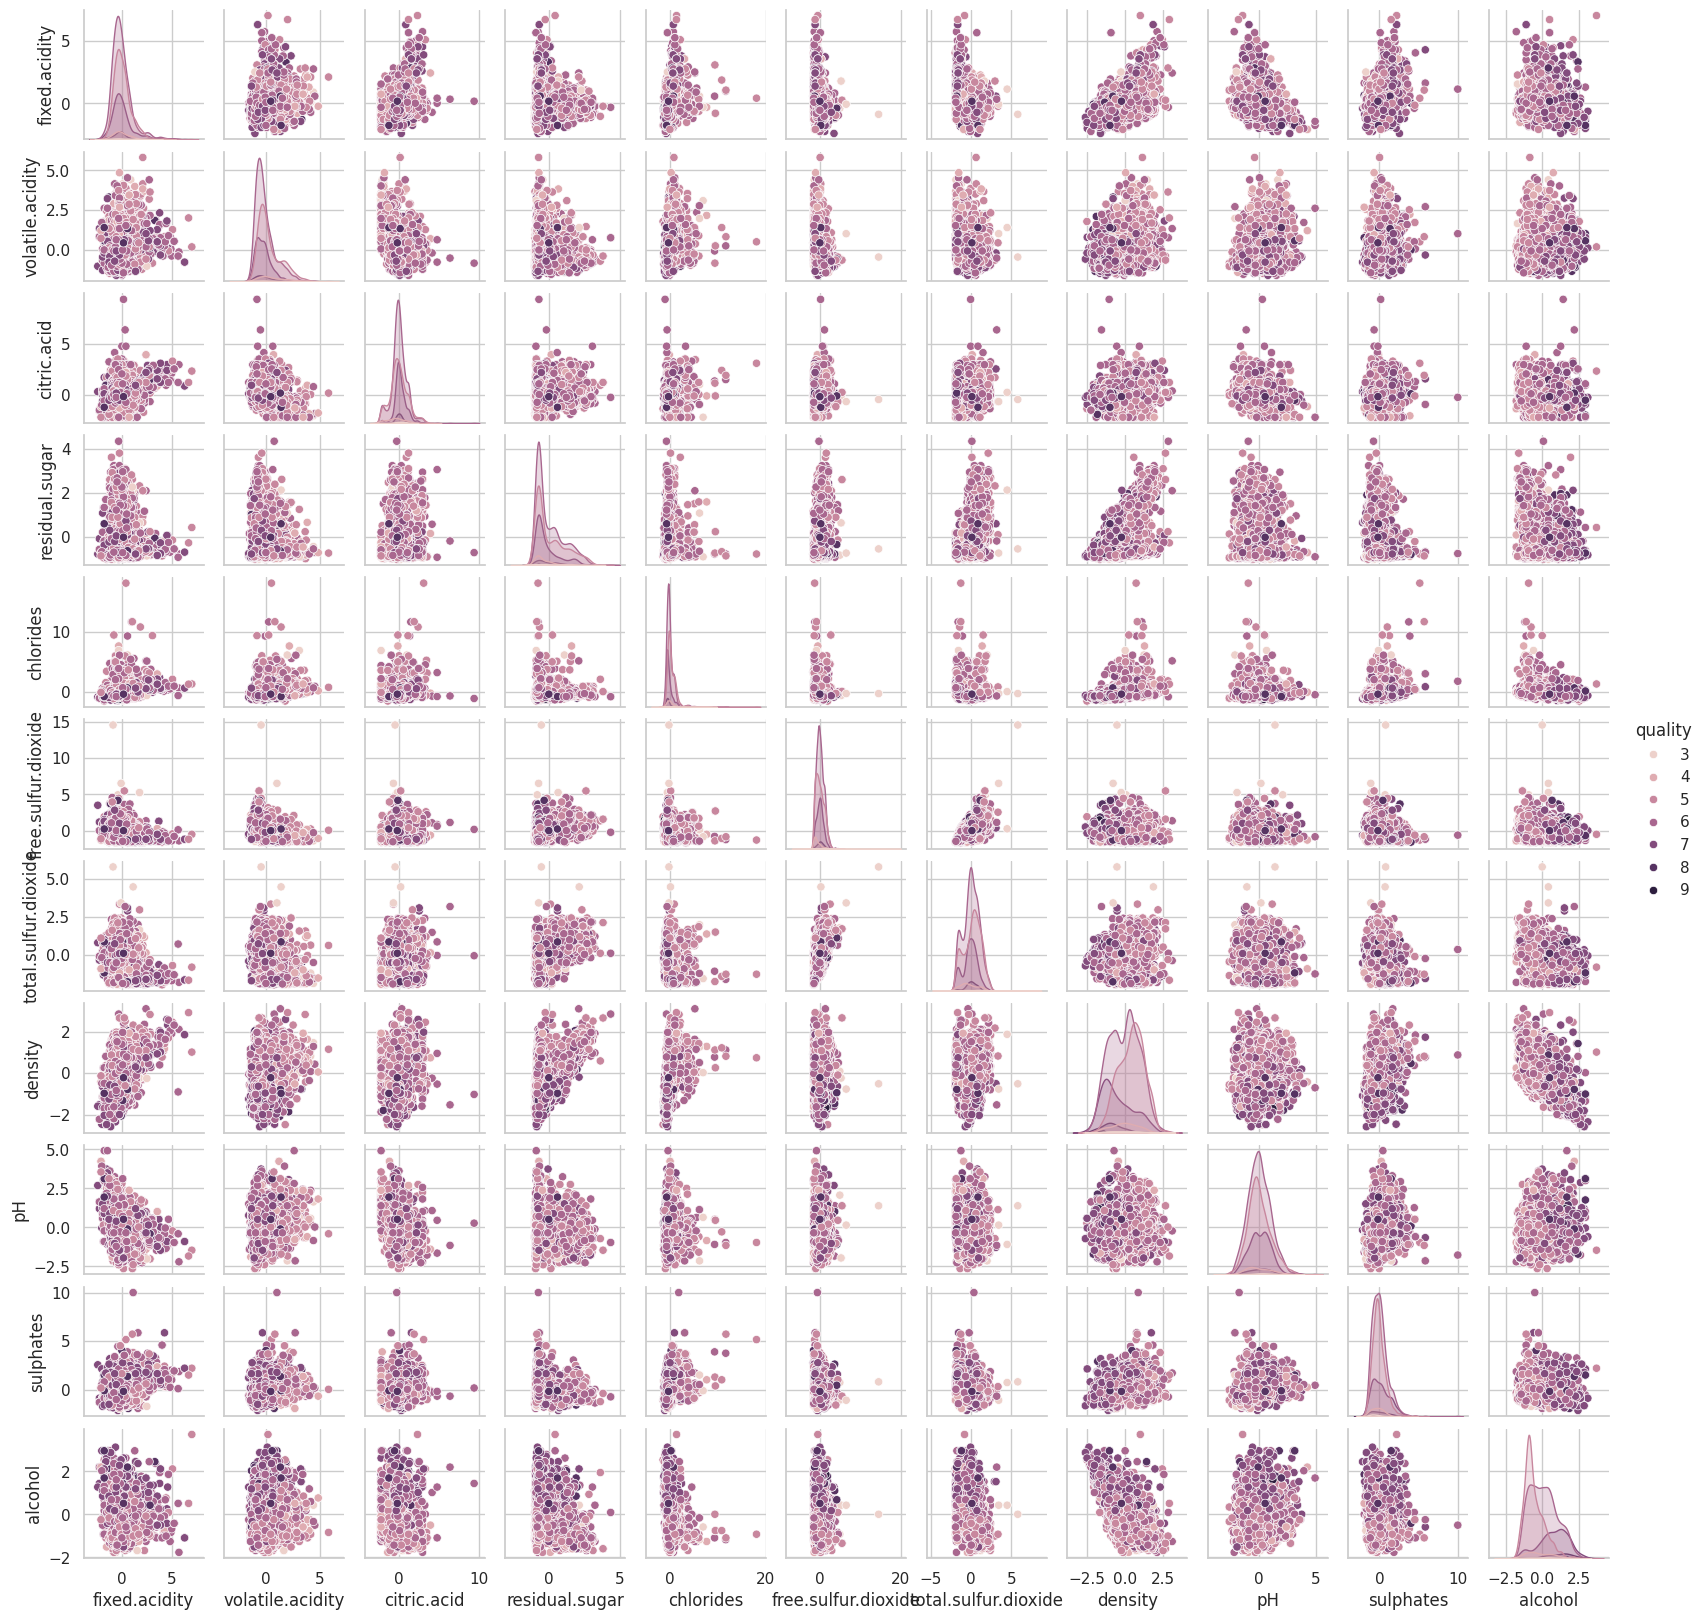

In [ ]:
%matplotlib inline
import seaborn as sns
sns.pairplot(df_mean, hue='quality', height=1.5);

This is a very interesting visualization. The most important thing to notice is the diagonal. This shows more than just correlation between quality and a dimension, it shows the correlation between dimensions and quality level. Important takeaways:

*     low density + high sulphates = high quality
*     high alcohol leads to high quality

*    Higher alcohol has a higher frequency of high quality records
*    ph is almost normally distributed for all quality levels, could be a dimension removed because not much information will be gained from it
*    Low density has a higher frequency of high quality records
*    Low chlorides has a higher frequency of high quality records
*    Fixed.acidity is almost normally distributed for all quality levels, could be a dimension removed because not much information will be gained from it

All of these observations are reinforced in other rows/columns. The bottom row, whcih has alcohol represented by the y axis has dark purple at the top of all the graphsl That show that higher alcohol leads to higher quality.

Let's run the same with our df_mean_z3 dataset to see if it replicated.

# Feature Selection


RFE run to determine the optimal amount of features. The optimal amount for the model could be 4, 6, or 8

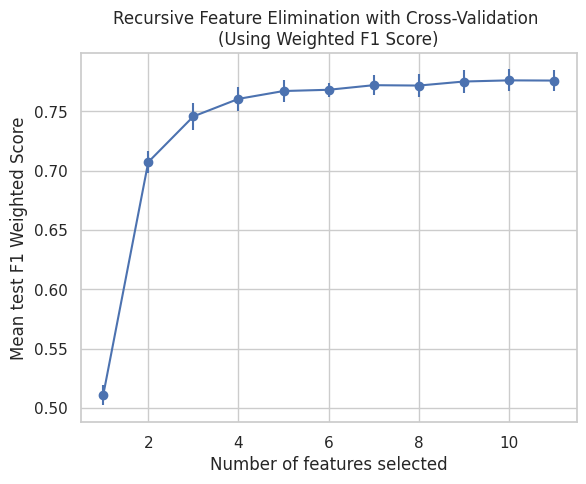

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Generate a synthetic multi-class imbalanced dataset
X = df_mean.drop(columns=['quality'])
y = df_mean['quality']


# Create a classifier
classifier = RandomForestClassifier(random_state=42)

# Create RFECV with F1 weighted scoring
rfecv = RFECV(estimator=classifier, step=1, cv=StratifiedKFold(5), scoring='f1_weighted', min_features_to_select=1)
rfecv.fit(X, y)

# Retrieve the number of features selected in each step
n_scores = len(rfecv.cv_results_["mean_test_score"])

# Plotting the F1 weighted scores as a function of the number of features
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test F1 Weighted Score")
plt.errorbar(
    range(1, n_scores + 1),  # Adjusted the range to start from 1 for clarity
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
    fmt='-o',  # Added marker style for better visualization
)
plt.title("Recursive Feature Elimination with Cross-Validation \n(Using Weighted F1 Score)")
plt.show()


The importance of each feature was calculated using Recursive Feature Elimination. The features were removed using mean mse to determine the best model.

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Assuming 'df_mean' is your DataFrame prepared with features and target
X = df_mean.drop(columns=['quality'])
y = df_mean['quality']

# Find the minimum class size and set n_splits appropriately for KFold
min_sample_size = y.shape[0]  # Since we're not dealing with classes, use total number of samples
n_splits = min(5, min_sample_size)  # Ensures we do not exceed the number of available samples

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize an empty list to collect feature importances and MSE scores
feature_importances = []
mse_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize the RandomForestRegressor
    rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, criterion='squared_error', random_state=42)
    rf_regressor.fit(X_train, y_train)

    # Append the feature importances for each fold to the list
    feature_importances.append(rf_regressor.feature_importances_)

    # Predict on the test set and calculate MSE
    y_pred = rf_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Calculate the mean of feature importances across all folds
mean_feature_importances = np.mean(feature_importances, axis=0)
print("Mean Feature Importances:", mean_feature_importances)

# Print the average MSE score across all folds
print("Average MSE:", np.mean(mse_scores))


Mean Feature Importances: [0.06109945 0.09790964 0.06864708 0.0745189  0.08248649 0.0949558
 0.07925964 0.10708851 0.07117918 0.07876738 0.18408792]
Average MSE: 0.2608657052631579


The results of the features based on their importance. The importance was based on a model the produced the highest average mse, which was .260

In [ ]:
selected_features1 = ['chlorides', 'free.sulfur.dioxide', 'pH','residual.sugar', 'density',  'alcohol', 'citric.acid', 'volatile.acidity']

These 8 features were the most important determined by the mean feature importance as well as salcohol, density, and volatile acidity being selected because of their correlations

## Model Creation wiht Hyperparameter Tuning and Testing

First model that runs grid detection on a random forest regressor using the features that were kept. The best model was chosen based on mse.

In [144]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

# Example data loading and preprocessing
# df_mean = pd.read_csv('your_dataset.csv')  # Load your dataset
X = df_mean[selected_features1]
y = df_mean['quality']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RandomForestRegressor with a parameter grid
regressor = RandomForestRegressor(random_state=42)
param_distributions = {
    'n_estimators': [10, 50, 100],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 4],
    'min_samples_split': [2, 10],
    'max_features': ['auto', 'sqrt']
}

# K-Fold Cross-Validation setup
cv = KFold(n_splits=3)

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(regressor, param_distributions, n_iter=10, cv=cv, scoring='neg_mean_squared_error', refit=True, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best parameters found for MSE optimization:", random_search.best_params_)
print("Best MSE score from Randomized Search (negative value):", random_search.best_score_)

# Evaluate the model on the test set using the refitted model on the best parameters
y_pred = random_search.predict(X_test)

# Calculate and print evaluation metrics for regression
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for MSE optimization: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'squared_error'}
Best MSE score from Randomized Search (negative value): -0.33263759709989316
Mean Squared Error on Test Set: 0.26759600114343385


The results show the best parameters for the model that generated a model with an mse of .267

Runinng a model that uses all of the features to see the results without any hyperparameter tuning.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Example data and target
X = df_mean.drop(columns=['quality'])
y = df_mean['quality']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train your model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.2686655789473684


Generated and good MSE

Beginning of predictions being download of model all features.

In [ ]:
test_df = pd.read_csv(r'/content/drive/MyDrive/DM 2 Project/test_blinded.csv')

#df_test_cleaned = remove_outliers_z_score_verbose(test_df, z_threshold=3) #ignore_column='quality')

#df_test_cleaned_mm = min_max_normalize(test_df.copy())  # Cleaned Test data min-max normalized

df_test_cleaned_mean = normalize(test_df.copy())  # Cleaned test data mean/std normalized
#print(df_test_cleaned_mm.head)
#print(df_test_cleaned_mean.head)

In [ ]:
df_test_cleaned_mean = df_test_cleaned_mean.drop(columns=['ID'])

RFR_blind_test_predictions = model.predict(df_test_cleaned_mean)

test_df['predicted_quality'] = RFR_blind_test_predictions

RFR_result_df = test_df[['ID', 'predicted_quality']]

RFR_result_df.to_csv('/content/drive/MyDrive/DM 2 Project/RFR_blind_test_predictions_mean.csv', index=False)

End of predictions being downloaed

Random Forest Regressor model being created with hyperparametet tuning and all features present.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

# Example data loading and preprocessing
# df_mean = pd.read_csv('your_dataset.csv')  # Load your dataset
X = df_mean.drop(columns=['quality'])
y = df_mean['quality']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RandomForestRegressor with a parameter grid
regressor = RandomForestRegressor(random_state=42)
param_distributions = {
    'n_estimators': [10, 50, 100],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 4],
    'min_samples_split': [2, 10],
    'max_features': ['auto', 'sqrt']
}

# K-Fold Cross-Validation setup
cv = KFold(n_splits=3)

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(regressor, param_distributions, n_iter=10, cv=cv, scoring='neg_mean_squared_error', refit=True, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best parameters found for MSE optimization:", random_search.best_params_)
print("Best MSE score from Randomized Search (negative value):", random_search.best_score_)

# Evaluate the model on the test set using the refitted model on the best parameters
y_pred = random_search.predict(X_test)

# Calculate and print evaluation metrics for regression
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for MSE optimization: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'squared_error'}
Best MSE score from Randomized Search (negative value): -0.32479342864374683
Mean Squared Error on Test Set: 0.25484547368421057


Results were the parameters that generated a model with the lowest mean mse which was .254, the best mse so far.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Example data and target
X = df_mean.drop(columns=['quality'])
y = df_mean['quality']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train your model
model = RandomForestRegressor(n_estimators= 100, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= None, criterion= 'squared_error', random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.25484547368421057


Beginnng of Random Forest Regressor with all features predictions being downloaded.

In [ ]:
test_df = pd.read_csv(r'/content/drive/MyDrive/DM 2 Project/test_blinded.csv')

#df_test_cleaned = remove_outliers_z_score_verbose(test_df, z_threshold=3) #ignore_column='quality')

#df_test_cleaned_mm = min_max_normalize(test_df.copy())  # Cleaned Test data min-max normalized

df_test_cleaned_mean = normalize(test_df.copy())  # Cleaned test data mean/std normalized
#print(df_test_cleaned_mm.head)
#print(df_test_cleaned_mean.head)

In [ ]:
df_test_cleaned_mean = df_test_cleaned_mean.drop(columns=['ID'])

RFR1_blind_test_predictions = model.predict(df_test_cleaned_mean)

test_df['predicted_quality'] = RFR1_blind_test_predictions

RFR1_result_df = test_df[['ID', 'predicted_quality']]

RFR1_result_df.to_csv('/content/drive/MyDrive/DM 2 Project/RFR1_blind_test_predictions_mean.csv', index=False)

End of Random Forest Regressor with all features predictions being downloaded.

Hyperparameter tuning used for Random forest regressor using PCA for feature reduction

In [148]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
import pandas as pd

# Load data
X = df_mean.drop(columns=['quality'])
y = df_mean['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Number of components chosen
print("Number of PCA components:", pca.n_components_)

# Define the RandomForestRegressor with a parameter grid
regressor = RandomForestRegressor(random_state=42)
param_distributions = {
    'n_estimators': [50, 100, 200],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'log2', 'sqrt']
}

# K-Fold Cross-Validation setup
cv = KFold(n_splits=3)

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    regressor,
    param_distributions,
    n_iter=10,
    cv=cv,
    scoring='neg_mean_squared_error',
    refit=True,
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_train_pca, y_train)

# Output the best parameters and the best score
print("Best parameters found for MSE optimization:", random_search.best_params_)
print("Best MSE score from Randomized Search (negative value):", random_search.best_score_)

# Evaluate the model on the test set using the refitted model on the best parameters
y_pred = random_search.predict(X_test_pca)

# Calculate and print evaluation metrics for regression
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)


Number of PCA components: 9
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for MSE optimization: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'criterion': 'absolute_error'}
Best MSE score from Randomized Search (negative value): -0.368271849913322
Mean Squared Error on Test Set: 0.3132267631578947


Results of hyperparamet tuning for Random Forest Regressor using PCA for dimension reduction. Not great results, mse of .313.

Model that uses PCA for feature reduction for a random forest regressor model

In [10]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Load data
X = df_mean.drop(columns=['quality'])
y = df_mean['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Number of components chosen
print("Number of PCA components:", pca.n_components_)

# Initialize and train the RandomForestRegressor
regressor = RandomForestRegressor(n_estimators= 500, min_samples_split= 2, min_samples_leaf= 1, max_features= 'log2', max_depth= None, criterion= 'squared_error', random_state=42)
regressor.fit(X_train_pca, y_train)

# Predict on test data
y_pred = regressor.predict(X_test_pca)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)



Number of PCA components: 9
Mean Squared Error: 0.2684922947368421


Resulted in 9 PCA components that generated a model with an mse of .268

Beginning of random regressor model with PCA feature reduction download


In [11]:
test_df = pd.read_csv(r'/content/drive/MyDrive/DM 2 Project/test_blinded.csv')

#df_test_cleaned = remove_outliers_z_score_verbose(test_df, z_threshold=3) #ignore_column='quality')

#df_test_cleaned_mm = min_max_normalize(test_df.copy())  # Cleaned Test data min-max normalized

df_test_cleaned_mean = normalize(test_df.copy())  # Cleaned test data mean/std normalized
#print(df_test_cleaned_mm.head)
#print(df_test_cleaned_mean.head)

In [12]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd

# Assuming X_train is already defined and available (the training features)
# Example code to create the training features might be:
# X_train = df_train[selected_features1]  # df_train should be your training dataset

df_test_cleaned_mean = df_test_cleaned_mean.drop(columns=['ID'])

# Create a PCA pipeline
pca_pipeline = Pipeline([
    ('pca', PCA(n_components=0.95))  # Retain 95% of variance
])

# Fit the PCA pipeline on the training data
pca_pipeline.fit(X_train)

# Assuming 'blind_test_data' is your new dataset without the quality column and needs to be transformed
# For example:
blind_test_data = df_test_cleaned_mean  # Ensure it has the same features as the training set

# Transform the blind test set using the fitted PCA pipeline
transformed_blind_test_data = pca_pipeline.transform(blind_test_data)

# Now 'transformed_blind_test_data' is ready to be used for predictions

In [13]:
#df_test_cleaned_mean = df_test_cleaned_mean.drop(columns=['ID'])

PCA_blind_test_predictions = regressor.predict(transformed_blind_test_data)

test_df['predicted_quality'] = PCA_blind_test_predictions

PCA_result_df = test_df[['ID', 'predicted_quality']]

PCA_result_df.to_csv('/content/drive/MyDrive/DM 2 Project/PCA_blind_test_predictions_mean.csv', index=False)

End of random regressor model with PCA feature reduction download

Creating a gradient boost model that uses the random forest regressor theat used PCA feature reduction as its weak learner.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Load data
X = df_mean.drop(columns=['quality'])
y = df_mean['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Number of components chosen
print("Number of PCA components:", pca.n_components_)

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=None, criterion='squared_error', random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]

# Initialize the Stacking Regressor
stacked_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42),
    cv=5,
    passthrough=False,
    verbose=1
)

# Train the stacked model
stacked_regressor.fit(X_train_pca, y_train)

# Predict on test data using the stacked model
y_pred_stacked = stacked_regressor.predict(X_test_pca)

# Calculate MSE for the stacked model
mse_stacked = mean_squared_error(y_test, y_pred_stacked)
print("Mean Squared Error with Stacking:", mse_stacked)


Number of PCA components: 9
Mean Squared Error with Stacking: 0.3075615789473684


Generated the worst MSE out of all the models.

Beginning of gradient boost model download.

In [ ]:
test_df = pd.read_csv(r'/content/drive/MyDrive/DM 2 Project/test_blinded.csv')

#df_test_cleaned = remove_outliers_z_score_verbose(test_df, z_threshold=3) #ignore_column='quality')

#df_test_cleaned_mm = min_max_normalize(test_df.copy())  # Cleaned Test data min-max normalized

df_test_cleaned_mean = normalize(test_df.copy())  # Cleaned test data mean/std normalized
#print(df_test_cleaned_mm.head)
print(df_test_cleaned_mean.head)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd

# Assuming X_train is already defined and available (the training features)
# Example code to create the training features might be:
# X_train = df_train[selected_features1]  # df_train should be your training dataset

df_test_cleaned_mean = df_test_cleaned_mean.drop(columns=['ID'])

# Create a PCA pipeline
pca_pipeline = Pipeline([
    ('pca', PCA(n_components=0.95))  # Retain 95% of variance
])

# Fit the PCA pipeline on the training data
pca_pipeline.fit(X_train)

# Assuming 'blind_test_data' is your new dataset without the quality column and needs to be transformed
# For example:
blind_test_data = df_test_cleaned_mean  # Ensure it has the same features as the training set

# Transform the blind test set using the fitted PCA pipeline
transformed_blind_test_data = pca_pipeline.transform(blind_test_data)

# Now 'transformed_blind_test_data' is ready to be used for predictions

In [ ]:
#df_test_cleaned_mean = df_test_cleaned_mean.drop(columns=['ID'])

PCA_blind_test_predictions = regressor.predict(transformed_blind_test_data)

test_df['predicted_quality'] = PCA_blind_test_predictions

PCA_result_df = test_df[['ID', 'predicted_quality']]

PCA_result_df.to_csv('/content/drive/MyDrive/DM 2 Project/PCA_blind_test_predictions_mean.csv', index=False)

End of gradient boost model download.